# PHASE 3: Feature Engineering & Baseline Models

## Overview

This notebook builds upon the data ingested in Phase 2. We will transform the raw sensor data into meaningful features for machine learning and establish baseline performance metrics.

**Key Objectives:**
1. **Feature Engineering**:
   - Scale sensor data (MinMax/Standardization).
   - Generate rolling window aggregates (Mean, Std) to capture trends.
   - Create piecewise RUL targets for stable regression.
2. **Baseline Modeling**:
   - Train **XGBoost Regressor** for RUL prediction.
   - Train **Random Forest Classifier** for early warning detection (Failure within 30 days).
3. **Evaluation**:
   - Measure RMSE (Root Mean Squared Error) for regression.
   - Measure F1-Score and Confusion Matrix for classification.

**Inputs:** `data/processed/{train,val,test}_FD001.csv`
**Outputs:** Trained baseline models and feature-rich datasets.

In [1]:

import sys
import os
import logging
from pathlib import Path

# --- Setup Project Root ---
current_dir = Path.cwd()
project_root = None

for parent in [current_dir] + list(current_dir.parents):
    if (parent / "src").exists():
        project_root = parent
        break

if project_root is None:
    project_root = current_dir.parent
    print("⚠️ Warning: 'src' directory not found. Defaulting to parent.")

try:
    os.chdir(project_root)
except Exception as e:
    print(f"⚠️ Could not change working directory: {e}")

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"✅ Working Directory set to: {Path.cwd()}")

# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from src.config import settings
from src.logging_config import setup_logging

# Configure Logging & Plotting
setup_logging(log_level='INFO')
logger = logging.getLogger(__name__)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully")


✅ Working Directory set to: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures


2026-02-27 00:15:59 - root - INFO - Logging configured. Level: INFO, File: logs/ewis.log
2026-02-27 00:15:59 - root - INFO - Logging configured. Level: INFO, File: logs/ewis.log


✅ Libraries imported successfully


# Section 1: Load Data

Load the processed C-MAPSS splits produced by notebook 01 (train/val/test CSVs).

In [2]:
# ==================== LOAD ALL C-MAPSS SUBSETS (FD001 – FD004) ====================
# Instead of loading a single pre-processed file, we load ALL 4 raw subsets,
# combine them into one DataFrame with a 'subset' column, then split train/val.
from sklearn.model_selection import GroupShuffleSplit

PROCESSED_DIR = Path(project_root) / 'data' / 'processed'
RAW_DIR       = Path(project_root) / 'data' / 'raw' / 'CMAPSS'
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# C-MAPSS schema: 2 IDs + 3 op_settings + 21 sensors = 26 columns
COL_NAMES = (['engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3'] +
             [f'sensor_{i}' for i in range(1, 22)])

SUBSETS = ['FD001', 'FD002', 'FD003', 'FD004']

# ---------- 1. Load ALL raw C-MAPSS files ----------
print("📂 Loading ALL C-MAPSS subsets from raw data...\n")
train_pieces, test_pieces = [], []

for subset in SUBSETS:
    for kind, pieces in [('train', train_pieces), ('test', test_pieces)]:
        fpath = RAW_DIR / f'{kind}_{subset}.txt'
        if not fpath.exists():
            print(f"  ⚠️ {fpath.name} not found — skipping")
            continue
        df = pd.read_csv(fpath, sep=r'\s+', header=None)
        if df.shape[1] >= 26:
            df = df.iloc[:, :26]
        df.columns = COL_NAMES[:df.shape[1]]
        df['subset'] = subset
        pieces.append(df)
        print(f"  ✅ {kind}_{subset}: {len(df):>6,} rows, {df['engine_id'].nunique():>3} engines")

assert train_pieces, "❌ No train files found in data/raw/CMAPSS/"
assert test_pieces,  "❌ No test files found in data/raw/CMAPSS/"

full_train = pd.concat(train_pieces, ignore_index=True)
test_df    = pd.concat(test_pieces,  ignore_index=True)

print(f"\n📊 Combined Raw Data:")
print(f"   Train Total: {full_train.shape[0]:,} rows — "
      f"Engines per subset: {full_train.groupby('subset')['engine_id'].nunique().to_dict()}")
print(f"   Test Total:  {test_df.shape[0]:,} rows — "
      f"Engines per subset: {test_df.groupby('subset')['engine_id'].nunique().to_dict()}")

# ---------- 2. Train / Val split (80/20 by engine, grouped by subset+engine) ----------
composite_key = full_train['subset'] + '_' + full_train['engine_id'].astype(str)
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, va_idx = next(gss.split(full_train, groups=composite_key))

train_df = full_train.iloc[tr_idx].reset_index(drop=True)
val_df   = full_train.iloc[va_idx].reset_index(drop=True)

# ---------- 3. Identify sensor columns ----------
_meta = {'engine_id', 'cycle', 'op_setting_1', 'op_setting_2', 'op_setting_3',
         'RUL', 'RUL_clip', 'RUL_clipped', 'label_fail', 'max_cycle',
         'dataset_id', 'subset', 'RUL_end'}
sensor_cols = [c for c in train_df.columns if c not in _meta]

# ---------- 4. Verify no engine leakage ----------
tr_keys = set(train_df['subset'] + '_' + train_df['engine_id'].astype(str))
va_keys = set(val_df['subset'] + '_' + val_df['engine_id'].astype(str))
assert len(tr_keys & va_keys) == 0, "❌ ENGINE LEAKAGE in Train/Val split!"

# ---------- 5. Summary ----------
print(f"\n✅ Final Splits (all {full_train['subset'].nunique()} subsets combined):")
print(f"   Train: {train_df.shape}  engines={len(tr_keys)}")
print(f"   Val:   {val_df.shape}  engines={len(va_keys)}")
print(f"   Test:  {test_df.shape}")
print(f"   Sensor cols ({len(sensor_cols)}): {sensor_cols[:5]} ...")
print(f"   Subsets: {sorted(train_df['subset'].unique())}")
print("✅ No engine leakage between Train/Val.")
print(train_df.head(3))

📂 Loading ALL C-MAPSS subsets from raw data...

  ✅ train_FD001: 20,631 rows, 100 engines
  ✅ test_FD001: 13,096 rows, 100 engines
  ✅ train_FD002: 53,759 rows, 260 engines
  ✅ test_FD002: 33,991 rows, 259 engines
  ✅ train_FD003: 24,720 rows, 100 engines
  ✅ test_FD003: 16,596 rows, 100 engines
  ✅ train_FD004: 61,249 rows, 249 engines
  ✅ test_FD004: 41,214 rows, 248 engines

📊 Combined Raw Data:
   Train Total: 160,359 rows — Engines per subset: {'FD001': 100, 'FD002': 260, 'FD003': 100, 'FD004': 249}
   Test Total:  104,897 rows — Engines per subset: {'FD001': 100, 'FD002': 259, 'FD003': 100, 'FD004': 248}

✅ Final Splits (all 4 subsets combined):
   Train: (129029, 27)  engines=567
   Val:   (31330, 27)  engines=142
   Test:  (104897, 27)
   Sensor cols (21): ['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5'] ...
   Subsets: ['FD001', 'FD002', 'FD003', 'FD004']
✅ No engine leakage between Train/Val.
   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1 

# Section 2: Sensor Calibration & Scaling
Raw sensor values have different ranges (temperatures vs. pressures). We apply **MinMax Scaling** to normalize them between 0 and 1.
**Important:** The scaler is fitted ONLY on the training data to prevent data leakage.

In [3]:

# Step A — Drop constant sensors BEFORE scaling
# Detect dynamically from the COMBINED training data (not hardcoded for FD001 only).
# With all 4 subsets, sensors like sensor_1 may vary in FD002/FD004 even if
# constant in FD001/FD003 (multiple operating conditions create variance).
sensor_variances = train_df[sensor_cols].var()
CONSTANT_SENSORS = sensor_variances[sensor_variances < 1e-5].index.tolist()

if CONSTANT_SENSORS:
    for df_ in [train_df, val_df, test_df]:
        df_.drop(columns=CONSTANT_SENSORS, inplace=True, errors='ignore')
    sensor_cols = [c for c in sensor_cols if c not in CONSTANT_SENSORS]
    print(f"✅ Dropped {len(CONSTANT_SENSORS)} constant sensors (variance < 1e-5): {CONSTANT_SENSORS}")
else:
    print("✅ No constant sensors detected in combined data — all sensors have variance.")

print(f"   Active sensor cols: {len(sensor_cols)}")

# Step B — scale only the remaining active sensors
scaler = MinMaxScaler()
scaler.fit(train_df[sensor_cols])   # fit on TRAIN only — no leakage

train_df[sensor_cols] = scaler.transform(train_df[sensor_cols])
val_df[sensor_cols]   = scaler.transform(val_df[sensor_cols])
test_df[sensor_cols]  = scaler.transform(test_df[sensor_cols])

print("✅ Sensors scaled (MinMax, fit on train only)")
print(train_df[sensor_cols].describe().loc[['min', 'max', 'mean']].round(3))

✅ No constant sensors detected in combined data — all sensors have variance.
   Active sensor cols: 21
✅ Sensors scaled (MinMax, fit on train only)
      sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  sensor_6  sensor_7  \
min      0.000     0.000     0.000     0.000     0.000     0.000     0.000   
max      1.000     1.000     1.000     1.000     1.000     1.000     1.000   
mean     0.553     0.563     0.599     0.567     0.557     0.548     0.513   

      sensor_8  sensor_9  sensor_10  ...  sensor_12  sensor_13  sensor_14  \
min      0.000     0.000      0.000  ...      0.000      0.000      0.000   
max      1.000     1.000      1.000  ...      1.000      1.000      1.000   
mean     0.757     0.549      0.573  ...      0.513      0.888      0.543   

      sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  sensor_20  \
min       0.000      0.000      0.000      0.000      0.000       0.00   
max       1.000      1.000      1.000      1.000      1.000       1.00   
mean    

# Section 3: Feature Engineering - Rolling Aggregates
Degradation is a temporal process. Raw snapshots are noisy; trends are signal.
We compute rolling **Mean** and **Standard Deviation** over windows of size 5, 10, and 20 cycles.

*Note: We group by a composite key (`subset` + `engine_id`) so windows don't cross between different engines or subsets (FD001 engine 1 ≠ FD002 engine 1).*

In [6]:

# =============================================================================
# LEAK TEST (composite key: subset + engine_id)
# C-MAPSS train/test share raw engine IDs BY DESIGN (different physical engines).
# With all 4 subsets combined, raw IDs overlap across subsets, so we must use
# composite keys for the real leak check.
# =============================================================================
def make_keys(df):
    if 'subset' in df.columns:
        return set(df['subset'].astype(str) + '_' + df['engine_id'].astype(str))
    return set(df['engine_id'].astype(str))

train_keys = make_keys(train_df)
val_keys   = make_keys(val_df)
test_keys  = make_keys(test_df)

print(f"ℹ️  Train∩Test composite-key overlap: {len(train_keys & test_keys)} — expected by NASA dataset design (not a bug)")
print(f"✅ Real leak check (Train∩Val): {len(train_keys & val_keys)} — must be 0")
assert len(train_keys & val_keys) == 0, "ENGINE LEAKAGE in Train/Val split!"
print("✅ Train/Val split is clean.")

# =============================================================================
# ROLLING FEATURES (grouped by subset+engine composite key to prevent
# cross-subset contamination — FD001 engine 1 ≠ FD002 engine 1)
# =============================================================================
def add_rolling_features(df, windows=[5, 10, 20]):
    result = df.copy().sort_values(['subset', 'engine_id', 'cycle'] if 'subset' in df.columns else ['engine_id', 'cycle'])
    # Create composite key when multiple subsets are present
    if 'subset' in result.columns:
        result['_key'] = result['subset'].astype(str) + '_' + result['engine_id'].astype(str)
    else:
        result['_key'] = result['engine_id'].astype(str)
    for w in windows:
        grouped   = result.groupby('_key')[sensor_cols]
        roll_mean = grouped.rolling(window=w, min_periods=1).mean().reset_index(0, drop=True)
        roll_mean.columns = [f"{c}_avg_w{w}" for c in sensor_cols]
        roll_std  = grouped.rolling(window=w, min_periods=1).std().fillna(0).reset_index(0, drop=True)
        roll_std.columns  = [f"{c}_std_w{w}" for c in sensor_cols]
        result = pd.concat([result, roll_mean, roll_std], axis=1)
    result.drop(columns=['_key'], inplace=True)
    return result

print("\n⏳ Generating rolling features...")
train_feat = add_rolling_features(train_df)
val_feat   = add_rolling_features(val_df)
test_feat  = add_rolling_features(test_df)
print(f"✅ Done. Train shape: {train_feat.shape}")


ℹ️  Train∩Test composite-key overlap: 566 — expected by NASA dataset design (not a bug)
✅ Real leak check (Train∩Val): 0 — must be 0
✅ Train/Val split is clean.

⏳ Generating rolling features...
✅ Done. Train shape: (129029, 153)


# Section 4: Target Generation
We need two types of targets:
1. **RUL (Remaining Useful Life)**: Regression target. We will clip this at 125 (piecewise linear RUL) as is common in C-MAPSS literature.
2. **Failure Indicator**: Binary classification target. 1 if RUL <= 30 cycles, 0 otherwise.

In [7]:

DATA_RAW = Path(settings.data_raw_path)

def process_targets(df, is_test=False, rul_file=None):
    """
    Assign RUL labels:
    - Train/Val (run-to-failure): RUL = max_cycle_per_engine - current_cycle
    - Test (truncated): official RUL_FDxxx.txt provides RUL at the last observed cycle.
      Call this function per subset so engine_id 1 maps to the correct engine.
    """
    output = df.copy()

    if not is_test:
        # Use composite key [subset, engine_id] to prevent cross-subset contamination
        # (FD001 engine 1 ≠ FD002 engine 1 — different physical machines)
        group_cols = ['subset', 'engine_id'] if 'subset' in output.columns else ['engine_id']
        max_cycle = output.groupby(group_cols)['cycle'].transform('max')
        output['RUL'] = max_cycle - output['cycle']
    else:
        if not (rul_file and Path(rul_file).exists()):
            raise FileNotFoundError(
                f"❌ Official RUL file not found: {rul_file}\n"
                "Cannot compute test labels without it."
            )
        rul_df = pd.read_csv(rul_file, header=None, names=['RUL_end'])
        rul_df['engine_id'] = rul_df.index + 1

        output = output.merge(rul_df, on='engine_id', how='left')
        last_cycle = output.groupby('engine_id')['cycle'].transform('max')
        output['RUL'] = output['RUL_end'] + (last_cycle - output['cycle'])
        output.drop(columns=['RUL_end'], inplace=True)

    output['RUL_clip']   = output['RUL'].clip(upper=125)
    output['label_fail'] = (output['RUL'] <= 30).astype(int)
    return output

print("🎯 Generating targets...")

train_final = process_targets(train_feat, is_test=False)
val_final   = process_targets(val_feat,   is_test=False)

# Test: process each subset independently — engine IDs restart from 1 per subset
test_pieces = []
for sub in SUBSETS:
    sub_df = test_feat[test_feat['subset'] == sub].copy() if 'subset' in test_feat.columns else test_feat.copy()
    rul_file = DATA_RAW / 'CMAPSS' / f'RUL_{sub}.txt'
    try:
        test_pieces.append(process_targets(sub_df, is_test=True, rul_file=rul_file))
    except FileNotFoundError as e:
        print(f"  ⚠️  {e}")

test_final = pd.concat(test_pieces, ignore_index=True) if test_pieces else pd.DataFrame()

for name, df_ in [('Train', train_final), ('Val', val_final), ('Test', test_final)]:
    df_.dropna(subset=['RUL'], inplace=True)
    print(f"  {name:5s}: {df_.shape}  "
          f"RUL=[{df_['RUL'].min():.0f}–{df_['RUL'].max():.0f}]  "
          f"mean={df_['RUL'].mean():.1f}  "
          f"failure%={df_['label_fail'].mean()*100:.1f}%")

print("\nSample rows (train):")
print(train_final[['engine_id', 'subset', 'cycle', 'RUL', 'RUL_clip', 'label_fail']].head())

🎯 Generating targets...
  Train: (129029, 156)  RUL=[0–542]  mean=123.2  failure%=13.6%
  Val  : (31330, 156)  RUL=[0–493]  mean=118.9  failure%=14.1%
  Test : (104897, 156)  RUL=[6–553]  mean=162.6  failure%=2.5%

Sample rows (train):
   engine_id subset  cycle  RUL  RUL_clip  label_fail
0          1  FD001      1  191       125           0
1          1  FD001      2  190       125           0
2          1  FD001      3  189       125           0
3          1  FD001      4  188       125           0
4          1  FD001      5  187       125           0


# Section 5: Baseline Models
We will train two baseline models to establish performance benchmarks:
1. **XGBoost Regressor**: To predict the Piecewise RUL (`RUL_clip`).
2. **Random Forest Classifier**: To predict the near-failure state (`label_fail`).

In [ ]:

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score,
                              f1_score, classification_report, mean_absolute_error)
import numpy as np

# =============================================================================
# FEATURE SELECTION (fit on train only — no leakage)
# =============================================================================
drop_cols = ['engine_id', 'cycle', 'RUL', 'RUL_clip', 'label_fail',
             'op_setting_1', 'op_setting_2', 'op_setting_3', 'subset']
candidates = [c for c in train_final.columns
              if c not in drop_cols and train_final[c].dtype in ['float64', 'float32', 'int64', 'int32']]

vt = VarianceThreshold(threshold=1e-4)
vt.fit(train_final[candidates])
features = [f for f, keep in zip(candidates, vt.get_support()) if keep]
print(f"✅ {len(features)} features selected "
      f"(dropped {len(candidates)-len(features)} near-zero-variance).")

# =============================================================================
# DATA MATRICES
# =============================================================================
X_train     = train_final[features].values
y_train_reg = train_final['RUL_clip'].values
y_train_clf = train_final['label_fail'].values

X_val       = val_final[features].values
y_val_reg   = val_final['RUL_clip'].values
y_val_clf   = val_final['label_fail'].values

# Official C-MAPSS benchmark: evaluate test on the LAST CYCLE per engine only
# Use composite key (subset + engine_id) so FD001 engine 1 ≠ FD002 engine 1
if 'subset' in test_final.columns:
    test_last = test_final.groupby(['subset', 'engine_id']).last().reset_index()
else:
    test_last = test_final.groupby('engine_id').last().reset_index()
X_test_last = test_last[features].values
y_test_last = test_last['RUL_clip'].values
print(f"Test benchmark: {len(test_last)} engines (last cycle each)")  # Should be 708 with all 4 subsets

# =============================================================================
# METRIC HELPERS
# =============================================================================
def calculate_nasa_score(y_true, y_pred):
    d = np.asarray(y_pred, float) - np.asarray(y_true, float)
    return float(np.sum(np.where(d < 0, np.exp(-d/13)-1, np.exp(d/10)-1)))

def report(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    nasa = calculate_nasa_score(y_true, y_pred)
    print(f"  {label:24s} → RMSE={rmse:6.2f}  MAE={mae:6.2f}  R²={r2:+.4f}  NASA={nasa:.0f}")
    return rmse

# =============================================================================
# BASELINES (model must beat these)
# =============================================================================
print("\n👀 Dumb baselines:")
report(y_val_reg, np.full(len(y_val_reg), y_train_reg.mean()),     "Mean-of-train")
report(y_val_reg, np.full(len(y_val_reg), np.median(y_train_reg)), "Median-of-train")

# =============================================================================
# MODEL 1 — XGBoost RUL Regressor
# =============================================================================
print("\n🤖 Training XGBoost Regressor...")
xgb_reg = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=5,
    subsample=0.8,    colsample_bytree=0.8,
    reg_alpha=0.1,    reg_lambda=1.0,
    random_state=42,  n_jobs=-1
)
xgb_reg.fit(X_train, y_train_reg,
            eval_set=[(X_train, y_train_reg), (X_val, y_val_reg)],
            verbose=False)

print("  Results:")
train_rmse = report(y_train_reg,               xgb_reg.predict(X_train),    "Train (overfit check)")
val_rmse   = report(y_val_reg,                 xgb_reg.predict(X_val),      "Validation")
_          = report(y_test_last,               xgb_reg.predict(X_test_last), "Test (last-cycle only)")

ratio  = train_rmse / val_rmse
status = "✅ OK" if ratio > 0.70 else "⚠️  Likely overfit"
print(f"\n  Bias/Variance ratio (train/val RMSE) = {ratio:.2f}  {status}")

y_pred_reg = xgb_reg.predict(X_val)   # kept for visualisation cell

# =============================================================================
# MODEL 2 — Random Forest Failure Classifier
# =============================================================================
print("\n🌲 Training Random Forest Classifier...")
rf_clf = RandomForestClassifier(
    n_estimators=200, max_depth=8, min_samples_leaf=5,
    random_state=42,  n_jobs=-1
)
rf_clf.fit(X_train, y_train_clf)

y_pred_clf = rf_clf.predict(X_val)
print(f"  Validation → Accuracy={accuracy_score(y_val_clf, y_pred_clf):.4f}  "
      f"F1={f1_score(y_val_clf, y_pred_clf):.4f}")
print(classification_report(y_val_clf, y_pred_clf))

# =============================================================================
# PER-SUBSET EVALUATION TABLE (C-MAPSS academic benchmark requirement)
# FD001/FD003 ≈ RMSE ~15 (1 op condition); FD002/FD004 ≈ RMSE ~25 (6 conditions)
# =============================================================================
def nasa_score(y_true, y_pred):
    d = np.asarray(y_pred, float) - np.asarray(y_true, float)
    return float(np.sum(np.where(d < 0, np.exp(-d/13)-1, np.exp(d/10)-1)))

print('\n' + '='*75)
print(f'{"Model":<20} | {"Subset":<7} | {"RMSE":>6} | {"MAE":>6} | {"R²":>6} | {"NASA Score":>10}')
print('='*75)

for sub in ['FD001', 'FD002', 'FD003', 'FD004']:
    if 'subset' not in test_final.columns:
        print(f"  ⚠️  'subset' column missing — cannot split by {sub}")
        continue
    sub_test = test_final[test_final['subset'] == sub]
    if sub_test.empty:
        print(f"  ⚠️  No test rows found for {sub} — skipping")
        continue
    last_row = sub_test.groupby('engine_id').last().reset_index()
    sub_features = [f for f in features if f in last_row.columns]
    X_sub = last_row[sub_features].values
    y_sub = last_row['RUL_clip'].values

    for mname, model in [('XGBoost', xgb_reg), ('RF_Clf', rf_clf)]:
        try:
            y_p   = model.predict(X_sub)
            rmse  = np.sqrt(mean_squared_error(y_sub, y_p))
            mae   = mean_absolute_error(y_sub, y_p)
            r2    = r2_score(y_sub, y_p)
            nasa  = nasa_score(y_sub, y_p)
            print(f'{mname:<20} | {sub:<7} | {rmse:>6.2f} | {mae:>6.2f} | {r2:>+6.4f} | {nasa:>10.0f}')
        except Exception as e:
            print(f'{mname:<20} | {sub:<7} | ERROR: {e}')

print('='*75)


ValueError: could not convert string to float: 'FD001'

# Section 6: Evaluation & Visualization
Visualizing the performance of our models on specific engines and understanding which features drive predictions.

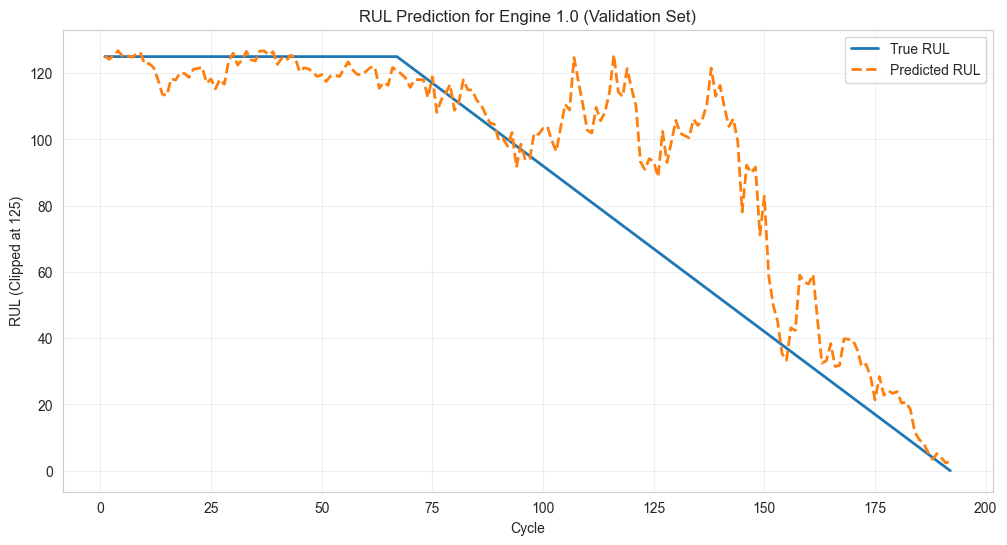

/var/folders/8t/bggqp3215xb0stby2r99gqcc0000gn/T/ipykernel_14785/4253092799.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


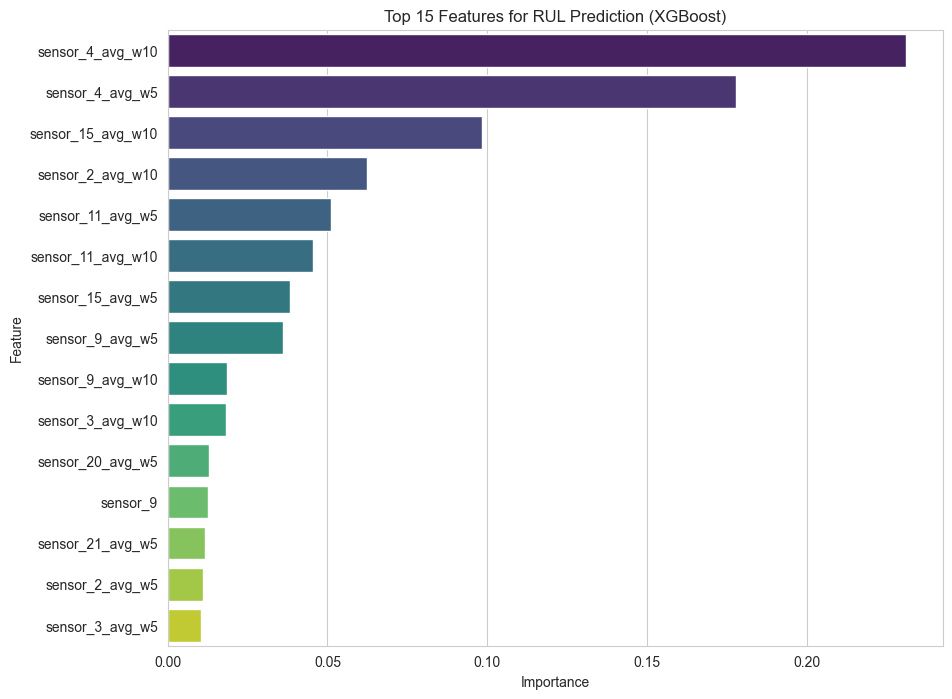

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. RUL Prediction Visualization for a Single Engine
sample_engine = val_final['engine_id'].unique()[0]
sample_data = val_final[val_final['engine_id'] == sample_engine]

X_sample = sample_data[features]
y_sample_true = sample_data['RUL_clip']
y_sample_pred = xgb_reg.predict(X_sample)

plt.figure(figsize=(12, 6))
plt.plot(sample_data['cycle'], y_sample_true, label='True RUL', linewidth=2)
plt.plot(sample_data['cycle'], y_sample_pred, label='Predicted RUL', linestyle='--', linewidth=2)
plt.title(f'RUL Prediction for Engine {sample_engine} (Validation Set)')
plt.xlabel('Cycle')
plt.ylabel('RUL (Clipped at 125)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Feature Importance
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_reg.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Top 15 Features for RUL Prediction (XGBoost)')
plt.show()

# Section 7: Save Models & Processed Data

Persist trained models and feature-enriched CSVs for use by downstream notebooks.

In [ ]:
import joblib
import os

# Create directories
os.makedirs(os.path.join(project_root, 'models'), exist_ok=True)
processed_dir = os.path.join(project_root, 'data', 'processed')

# Save Data
print("💾 Saving processed datasets...")
train_final.to_csv(os.path.join(processed_dir, 'train_features.csv'), index=False)
val_final.to_csv(os.path.join(processed_dir, 'val_features.csv'), index=False)
test_final.to_csv(os.path.join(processed_dir, 'test_features.csv'), index=False)

# Save Models
print("💾 Saving baseline models...")
joblib.dump(xgb_reg, os.path.join(project_root, 'models', 'xgb_rul_baseline.joblib'))
joblib.dump(rf_clf, os.path.join(project_root, 'models', 'rf_failure_baseline.joblib'))

print("✅ All artifacts saved successfully!")

💾 Saving processed datasets...
💾 Saving baseline models...
✅ All artifacts saved successfully!


# Section 8: Text Data Processing (Log Embeddings)

Generate sentence embeddings from the log corpus saved in Phase 2 for later use in the RAG pipeline.

In [ ]:
# ==================== 11. TEXT DATA PROCESSING ====================
print("\n--- TEXT DATA PROCESSING ---")

import os
import re
import pandas as pd
import numpy as np

# Detect project root correctly (Parent of 'notebooks')
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

# Paths
TEXT_DATA_PATH = os.path.join(project_root, 'data', 'interim', 'combined_text_corpus.csv')
EMBEDDING_DIR = os.path.join(project_root, 'data', 'processed', 'text_embeddings')
os.makedirs(EMBEDDING_DIR, exist_ok=True)

print(f"Looking for text data at: {TEXT_DATA_PATH}")

if os.path.exists(TEXT_DATA_PATH):
    try:
        text_df = pd.read_csv(TEXT_DATA_PATH)
        print(f"✅ Loaded text corpus: {len(text_df)} rows")
        
        if len(text_df) > 0:
            # 1. Text Cleaning
            print("Cleaning text...")
            def clean_text(text):
                if not isinstance(text, str): return ""
                text = text.lower() # Lowercase
                text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text) # Remove special chars
                text = re.sub(r'\s+', ' ', text).strip() # Normalize spaces
                return text
            
            # Identify text column
            col_name = 'line_content' if 'line_content' in text_df.columns else text_df.columns[0]
            text_df['cleaned_text'] = text_df[col_name].astype(str).apply(clean_text)

            # Drop empty strings (less than 5 chars)
            text_df = text_df[text_df['cleaned_text'].str.len() > 5].reset_index(drop=True)
            print(f"✅ Cleaned text: {len(text_df)} valid entries")
            
            if len(text_df) > 0:
                # 2. Embedding Generation (Sentence-BERT)
                try:
                    from sentence_transformers import SentenceTransformer
                    print("Loading Sentence-BERT model (all-MiniLM-L6-v2)...")
                    # Use a lightweight model
                    model = SentenceTransformer('all-MiniLM-L6-v2')
                    
                    # Generate Embeddings
                    print(f"Generating Embeddings for {len(text_df)} chunks...")
                    sentences = text_df['cleaned_text'].tolist()
                    embeddings = model.encode(sentences, show_progress_bar=True)
                    
                    # 3. Store Embeddings
                    embedding_path = os.path.join(EMBEDDING_DIR, 'log_embeddings.npy')
                    metadata_path = os.path.join(EMBEDDING_DIR, 'log_metadata.csv')
                    
                    np.save(embedding_path, embeddings)
                    # Save metadata (source + text)
                    if 'source_file' in text_df.columns:
                        text_df[['source_file', 'cleaned_text']].to_csv(metadata_path, index=False)
                    else:
                        text_df[['cleaned_text']].to_csv(metadata_path, index=False)
                    
                    print(f"✅ Embeddings saved to: {embedding_path} (Shape: {embeddings.shape})")
                    print(f"✅ Metadata saved to: {metadata_path}")
                    
                except ImportError:
                    print("⚠️ 'sentence-transformers' not installed.")
                    print("To generate embeddings, run: pip install sentence-transformers")
                except Exception as e:
                    print(f"❌ Error during embedding generation: {e}")
            else:
                 print("⚠️ No valid text remaining after cleaning.")
    except Exception as e:
        print(f"❌ Error reading text file: {e}") 
else:
    print("⚠️ No text corpus found. Please ensure 'data/interim/combined_text_corpus.csv' exists.")
    # Fallback: Create placeholder if needed or just skip
    print("Skipping text processing.")


--- TEXT DATA PROCESSING ---
Looking for text data at: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/interim/combined_text_corpus.csv
✅ Loaded text corpus: 6 rows
Cleaning text...
✅ Cleaned text: 6 valid entries


/Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/.venv/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-26 21:00:27 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2026-02-26 21:00:27 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Loading Sentence-BERT model (all-MiniLM-L6-v2)...


2026-02-26 21:00:27 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json "HTTP/1.1 307 Temporary Redirect"
2026-02-26 21:00:27 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/sentence-transformers/all-MiniLM-L6-v2/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/modules.json "HTTP/1.1 200 OK"
2026-02-26 21:00:27 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config_sentence_transformers.json "HTTP/1.1 307 Temporary Redirect"
2026-02-26 21:00:27 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/sentence-transformers/all-MiniLM-L6-v2/c9745ed1d9f207416be6d2e6f8de32d1f16199bf/config_sentence_transformers.json "HTTP/1.1 200 OK"
2026-02-26 21:00:27 - httpx - INFO - HTTP Request: HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/config_sentence_transformers.json "HTTP/1

Generating Embeddings for 6 chunks...


Batches: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]

✅ Embeddings saved to: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed/text_embeddings/log_embeddings.npy (Shape: (6, 384))
✅ Metadata saved to: /Users/xe/Documents/GITHUB CAPSTONE /Agentic-Early-Warning-Intelligence-System-for-Silent-System-Failures/data/processed/text_embeddings/log_metadata.csv
